In [1]:
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

from typing import Literal
from dotenv import load_dotenv
from typing_extensions import Annotated, TypedDict

import os

load_dotenv()

True

In [2]:
deepseek_model = ChatOllama(
    model="deepseek-r1:70b", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
mixtral_model = ChatOllama(
    model="dolphin-mixtral:latest", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
llama3_model = ChatOllama(
    model="llama3.2:3b", base_url=os.environ.get("LLAMA_URL"), temperature=2
)
gpt_model = ChatOpenAI(temperature=1, model="gpt-4o-mini")

llm = gpt_model

In [3]:
class Configuration(TypedDict, total=False):
    max_depth: int
    max_candidates: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 5),
        "max_candidates": configurable.get("max_candidates", 2),
    }

In [4]:
from langchain_core.runnables import Runnable
from typing import TypedDict
from pydantic import BaseModel
from ai.abstract_agent import Agent
from langchain_core.prompts import PromptTemplate
from langgraph.graph import MessagesState, START, END
from operator import add


class CoTState(MessagesState):
    intermediate_steps: Annotated[list[str], add]
    last_step: bool


class ThoughtSchema(BaseModel):
    thought: str
    finish: bool


thinker_template = """
{{ system_prompt }}.

Before executing the task, think deeply about the next step to solve the task given by the user.
The tought you will give is the step of how to complete given by the user task.
The purpose of the thoughts is to break the problem into smaller steps.
Already taken steps: 
{% if steps %}{{ steps }}{% else %}This is your first step to solve this problem.{% endif %}

What is the next step to solve this problem? Is it the last step thast must be taken to complete the task?
Return only the next step in one sentence.
"""

thinker_prompt = PromptTemplate(
    template=thinker_template,
    input_variables=["system_prompt", "intermediate_steps"],
    template_format="jinja2",
)

system_prompt = "You are helpful code assistant."


def reasoning_node(state: CoTState) -> CoTState:
    if "intermediate_steps" in state and state["intermediate_steps"]:
        formatted_prompt = thinker_prompt.format(
            system_prompt=system_prompt,
            steps="\n".join(
                [f"{n+1}. {step}" for n, step in enumerate(state["intermediate_steps"])]
            ),
        )
    else:
        formatted_prompt = thinker_prompt.format(system_prompt=system_prompt)

    thought = (
        llm.with_structured_output(ThoughtSchema)
        .invoke([("system", formatted_prompt), state["messages"][-1]])
        .model_dump()
    )

    return {
        "intermediate_steps": [thought["thought"]],
        "last_step": thought["finish"],
    }


def should_continue(
    state: CoTState, config: RunnableConfig
) -> Literal["reasoning_node", "__end__"]:
    max_depth = _ensure_configurable(config).get("max_depth")
    if state["last_step"] or len(state["intermediate_steps"]) >= max_depth:
        return "__end__"
    return "reasoning_node"


class CoTAgent(Agent):
    def __init__(self, llm: Runnable, system_prompt: str):
        self.llm = llm
        self.system_prompt = system_prompt

    def invoke(self):
        # self.llm.invoke([
        #     ("system", "")
        # ])
        pass

In [5]:
graph_builder = StateGraph(CoTState, config_schema=Configuration)

graph_builder.add_node("reasoning_node", reasoning_node)

graph_builder.add_edge(START, "reasoning_node")
graph_builder.add_conditional_edges(
    "reasoning_node", should_continue, ["reasoning_node", "__end__"]
)
cot_graph = graph_builder.compile()

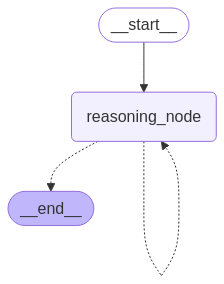

In [6]:
from IPython.display import Image, display

display(Image(cot_graph.get_graph().draw_mermaid_png()))

In [7]:
user_prompt = "Create pacman game in python"

In [8]:
cot_state = cot_graph.invoke(
    {"messages": [("user", user_prompt)]}, config={"max_depth": 10}
)

In [9]:
cot_state["intermediate_steps"]

['Plan out the game structure, including understanding the main game loop, defining the game states, and determining how to handle user input for controlling Pac-Man.',
 'Implement the rendering of the game window using a graphical library such as Pygame to visually display the game elements like Pac-Man, walls, and dots.',
 'Implement the game logic, including collision detection between Pac-Man and walls, ghosts, and dots, along with scoring and game over conditions.',
 'The next step is to implement the ghost AI behavior to ensure they chase Pac-Man appropriately, adding difficulty to the game.',
 'After implementing the ghost AI behavior, the next step is to add power-ups that can temporarily change the behavior of ghosts, allowing Pac-Man to eat them for extra points and incorporating a timer for this power-up effect.',
 "Implement the scoring system to track and display the player's score as they collect dots and defeat ghosts, ensuring the game updates the score in real-time.",


## ToT


In [10]:
class TreeNode:
    def __init__(self, thought, finish=False, score=None):
        self.thought = thought
        self.finish = finish
        self.score = score
        self.children = []

    def add_child(self, thought, finish=False, score=None):
        """Add a child node with the given thought, finish status, and score"""
        child = TreeNode(thought, finish, score)
        self.children.append(child)
        return child

    def remove_child(self, thought):
        """Remove a direct child node with the given thought"""
        for i, child in enumerate(self.children):
            if child.thought == thought:
                return self.children.pop(i)
        return None

    def __str__(self, level=0):
        """String representation of the node and its children with indentation"""
        score_str = f", score: {self.score}" if self.score is not None else ""
        result = (
            "  " * level
            + f"{{thought: '{self.thought}', finish: {self.finish}{score_str}}}\n"
        )
        for child in self.children:
            result += child.__str__(level + 1)
        return result

    def is_leaf(self):
        """Check if the node is a leaf node (has no children)"""
        return len(self.children) == 0


class ThoughtTree:
    def __init__(self, root_thought="Root", root_score=None):
        """Initialize the tree with a root node"""
        self.root = TreeNode(root_thought, score=root_score)

    def find_node(self, thought, node=None):
        """Find a node with the given thought"""
        if node is None:
            node = self.root

        if node.thought == thought:
            return node

        for child in node.children:
            result = self.find_node(thought, child)
            if result:
                return result

        return None

    def find_parent(self, thought, node=None, parent=None):
        """Find the parent of a node with the given thought"""
        if node is None:
            node = self.root

        # Check if any of this node's children match the target
        for child in node.children:
            if child.thought == thought:
                return node

        # Recursively check all children
        for child in node.children:
            result = self.find_parent(thought, child, node)
            if result:
                return result

        return None

    def add_thought(self, parent_thought, new_thought, finish=False, score=None):
        """Add a thought node as a child of the parent thought node with optional score"""
        parent = self.find_node(parent_thought)
        if parent:
            return parent.add_child(new_thought, finish, score)
        else:
            raise ValueError(f"Parent thought '{parent_thought}' not found in the tree")

    def set_score(self, thought, score):
        """Set the score for a node"""
        node = self.find_node(thought)
        if node:
            node.score = score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_score(self, thought):
        """Get the score for a node"""
        node = self.find_node(thought)
        if node:
            return node.score
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_highest_scoring_nodes(self, count=1):
        """Return the highest scoring nodes"""
        nodes_with_scores = []

        def collect_scored_nodes(node):
            if node.score is not None:
                nodes_with_scores.append((node.thought, node.score))
            for child in node.children:
                collect_scored_nodes(child)

        collect_scored_nodes(self.root)
        # Sort by score in descending order
        sorted_nodes = sorted(nodes_with_scores, key=lambda x: x[1], reverse=True)
        return sorted_nodes[:count]

    def remove_node(self, thought, preserve_children=True):
        """
        Remove a node from the tree

        Args:
            thought: The thought content of the node to remove
            preserve_children: If True, the children of the removed node
                              will be attached to the parent of the removed node.
                              If False, the entire subtree will be removed.

        Returns:
            The removed node
        """
        # Cannot remove the root node
        if thought == self.root.thought:
            raise ValueError("Cannot remove the root node")

        # Find the parent of the node to remove
        parent = self.find_parent(thought)
        if not parent:
            raise ValueError(f"Thought '{thought}' not found in the tree")

        # Find the node to remove
        node_to_remove = None
        for i, child in enumerate(parent.children):
            if child.thought == thought:
                node_to_remove = parent.children.pop(i)
                break

        # If we want to preserve the children, attach them to the parent
        if preserve_children and node_to_remove:
            for child in node_to_remove.children:
                parent.children.append(child)

        return node_to_remove

    def mark_as_finished(self, thought):
        """Mark a thought node as finished"""
        node = self.find_node(thought)
        if node:
            node.finish = True
        else:
            raise ValueError(f"Thought '{thought}' not found in the tree")

    def get_leaf_nodes(self):
        """Return all leaf nodes (nodes with no children)"""
        leaves = []

        def collect_leaves(node):
            if node.is_leaf():
                leaf_data = {"thought": node.thought, "finish": node.finish}
                if node.score is not None:
                    leaf_data["score"] = node.score
                leaves.append(leaf_data)
            else:
                for child in node.children:
                    collect_leaves(child)

        collect_leaves(self.root)
        return leaves

    def get_all_paths(self):
        """Return all paths from root to each leaf node or finished node"""
        all_paths = []

        def dfs(node, current_path):
            # Add current node to the path
            node_data = {"thought": node.thought, "finish": node.finish}
            if node.score is not None:
                node_data["score"] = node.score
            current_path.append(node_data)

            # If it's a leaf node or a finished node, add the path to all_paths
            if node.is_leaf() or node.finish:
                all_paths.append(current_path.copy())

            # Continue DFS for each child
            for child in node.children:
                dfs(child, current_path.copy())

        # Start DFS from root
        dfs(self.root, [])
        return all_paths

    def get_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [path for path in all_paths if path[-1]["finish"]]

    def get_not_finished_paths(self):
        """Return all paths that end with a finished node"""
        all_paths = self.get_all_paths()
        return [
            path
            for path in all_paths
            if not path[-1]["finish"] or "score" not in path[-1]
        ]

    def are_all_paths_finished(self):
        return len(self.get_all_paths()) == len(self.get_finished_paths())

    def get_highest_scoring_path(self):
        """Return the path with the highest cumulative score"""
        all_paths = self.get_all_paths()

        if not all_paths:
            return None

        # Calculate sum of scores for each path (ignoring nodes without scores)
        path_scores = []
        for path in all_paths:
            total_score = sum(node.get("score", 0) for node in path)
            path_scores.append((path, total_score))

        # Return the path with the highest total score
        return max(path_scores, key=lambda x: x[1])

    def __str__(self):
        """String representation of the entire tree"""
        return str(self.root)

In [11]:
class ToTState(MessagesState):
    tree: ThoughtTree
    propositions: list[ThoughtSchema]
    goal: str
    depth: Annotated[int, add]
    intermediate_steps: list[str]


def create_goal(state: ToTState) -> ToTState:
    output = llm.invoke(
        [
            (
                "system",
                "State the goal of the user. In one short sentece. Tell what is the user intention.",
            ),
            state["messages"][-1],
        ]
    ).content
    return {"goal": output}


def reasoning_node(state: ToTState) -> ToTState:
    if "tree" in state and state["tree"]:
        propositions = []
        for path in state["tree"].get_not_finished_paths():
            formatted_prompt = thinker_prompt.format(
                system_prompt=system_prompt,
                steps="\n".join(
                    [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
                ),
            )
            prompts = [
                [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
            ]
            thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
            thoughts = [t.model_dump() for t in thoughts]
            propositions.append(thoughts)

        return {"propositions": propositions, "depth": 1}
    else:
        formatted_prompt = thinker_prompt.format(system_prompt=system_prompt)
        prompts = [
            [("system", formatted_prompt), state["messages"][-1]] for _ in range(5)
        ]

        thoughts = llm.with_structured_output(ThoughtSchema).batch(prompts)
        thoughts = [t.model_dump() for t in thoughts]

        return {"propositions": [thoughts], "depth": 0}


def build_tree(state: ToTState) -> ToTState:
    propositions = state.get("propositions", [[]])
    tree = state.get("tree", ThoughtTree(state["goal"]))
    for leaf, propositions_for_leaf in zip(tree.get_leaf_nodes(), propositions):
        for prop in propositions_for_leaf:
            tree.add_thought(leaf["thought"], prop["thought"], prop["finish"])
    return {"tree": tree, "depth": 0}


def score_and_prune(state: ToTState, config: RunnableConfig) -> ToTState:
    class Scores(BaseModel):
        score: int
        reason: str

    tree = state["tree"]
    config = _ensure_configurable(config)
    system_prompt = (
        "Your task is to critisize the plan for achieving given goal."
        "Assign points from 1 to 10."
    )
    prompts = []
    paths = tree.get_not_finished_paths()

    for path in paths:
        steps = "\n".join(
            [f"{n+1}. {thought['thought']}" for n, thought in enumerate(path)]
        )
        prompts.append(
            [
                ("system", system_prompt),
                (
                    "user",
                    "Goal: "
                    "{goal} \n"
                    "Plan:"
                    "{plan}".format(goal=state["goal"], plan=steps),
                ),
            ]
        )
    scores = llm.with_structured_output(Scores).batch(prompts)
    scores = [s.model_dump()["score"] for s in scores]

    paths_scores = list(zip(paths, scores))
    paths_scores_sorted = list(sorted(paths_scores, key=lambda x: x[-1], reverse=True))

    for path, score in paths_scores_sorted[: config.get("max_candidates")]:
        tree.set_score(path[-1]["thought"], score)

    for path, _ in paths_scores_sorted[config.get("max_candidates") :]:
        tree.remove_node(path[-1]["thought"])

    return {"tree": tree, "depth": 0}


def should_continue(
    state: ToTState, config: Configuration
) -> Literal["format_response", "reasoning_node"]:
    config = _ensure_configurable(config)
    if state["tree"].are_all_paths_finished() or state["depth"] >= config.get(
        "max_depth"
    ):
        return "format_response"
    return "reasoning_node"


def format_response(state: ToTState):
    return {
        "intermediate_steps": [
            t["thought"] for t in state["tree"].get_highest_scoring_path()[0]
        ]
    }

In [12]:
graph_builder = StateGraph(ToTState, config_schema=Configuration)

graph_builder.add_node("create_goal", create_goal)
graph_builder.add_node("reasoning_node", reasoning_node)
graph_builder.add_node("build_tree", build_tree)
graph_builder.add_node("score_and_prune", score_and_prune)
graph_builder.add_node("format_response", format_response)

graph_builder.add_edge(START, "create_goal")
graph_builder.add_edge("create_goal", "reasoning_node")
graph_builder.add_edge("reasoning_node", "build_tree")
graph_builder.add_edge("build_tree", "score_and_prune")
graph_builder.add_conditional_edges(
    "score_and_prune", should_continue, ["format_response", "reasoning_node"]
)
graph_builder.add_edge("format_response", END)

tot_graph = graph_builder.compile()

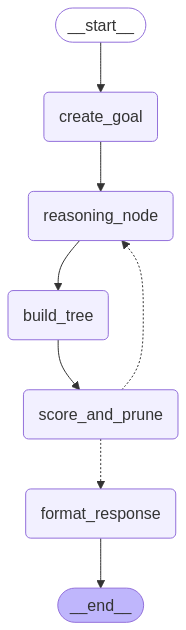

In [13]:
from IPython.display import Image, display

display(Image(tot_graph.get_graph().draw_mermaid_png()))

In [14]:
user_prompt = "Create pacman game in python"
tot_state = tot_graph.invoke(
    {"messages": [("user", user_prompt)]}, config={"max_depth": 6}
)

In [15]:
tot_state["intermediate_steps"]

['The user intends to create a Pac-Man game using Python programming.',
 'Break down the game into components such as the game window, player (Pacman), ghosts, and the maze environment, and then start by setting up a basic game window using a library like Pygame.',
 'Implement the game loop that includes event handling, updating game states, and rendering the game elements to the screen.',
 'Implement the maze layout and ensure Pacman can move around the maze using keyboard inputs while detecting walls and boundaries.',
 'Next, implement the mechanics for the ghosts, including their movement patterns and behavior towards Pacman, as well as the logic for collision detection between Pacman and the ghosts.',
 'Implement the scoring system for collecting pellets, as well as the game over conditions for when Pacman is caught by a ghost or all pellets are collected.',
 'The next step is to finalize the game by adding sound effects and visual polish, ensuring that the game elements are visual

In [16]:
print(tot_state["tree"])

{thought: 'The user intends to create a Pac-Man game using Python programming.', finish: False}
  {thought: 'Break down the game into components such as the game window, player (Pacman), ghosts, and the maze environment, and then start by setting up a basic game window using a library like Pygame.', finish: False, score: 7}
    {thought: 'Implement the game loop that includes event handling, updating game states, and rendering the game elements to the screen.', finish: False, score: 7}
      {thought: 'Implement the maze layout and ensure Pacman can move around the maze using keyboard inputs while detecting walls and boundaries.', finish: False, score: 7}
        {thought: 'Next, implement the mechanics for the ghosts, including their movement patterns and behavior towards Pacman, as well as the logic for collision detection between Pacman and the ghosts.', finish: False, score: 8}
          {thought: 'Implement the scoring system for collecting pellets, as well as the game over condit

In [768]:
cot_state["intermediate_steps"][:-1]

['Plan the game structure by defining the main components such as the game loop, player movement, ghost behaviors, and maze layout.',
 'Implement the maze layout by creating a 2D grid representation of the maze and defining the walls, paths, and positions of food pellets and power-ups.',
 'Implement the player movement logic by defining how the player can navigate through the maze using keyboard inputs while colliding with walls and collecting pellets.',
 'Implement ghost behaviors with AI that allows them to move around the maze, chase the player, and react to power-up states.',
 "Implement scoring and lives system to keep track of the player's score for collected pellets and remaining lives after being caught by ghosts, and display this information on the screen during gameplay.",
 'Implement the game loop that continuously updates the game state, processes player input, updates ghost movements, checks for collisions, and renders the game graphics until the game ends.',
 'Test the ga

In [ ]:
from langchain_core.prompts.chat import MessagesPlaceholder
from langgraph.prebuilt import ToolNode, tools_condition

system_prompt = ""

coder_system_prompt = """You are coder expert. Your task is to write high quaility code. You get access to many of tools that helps you write code."""
coder_template = ChatPromptTemplate(
    [
        ("system", coder_system_prompt),
        ("ai", "Your plan to execute the task: \n{intermediate_steps}"),
        MessagesPlaceholder("messages"),
    ]
)

tools = []
tool_node = ToolNode(tools)


class CoderAgentState(MessagesState):
    current_dir: str
    intermediate_steps: list[str]


def reason(state: CoderAgentState) -> CoderAgentState:
    steps = tot_graph.invoke({"messages": state.get("messages")}).get(
        "intermediate_steps"
    )
    return {"intermediate_steps": "\n".join(steps)}


def llm_node(state: CoderAgentState) -> CoderAgentState:
    runnable = coder_template | llm.bind_tools(tools)
    output = runnable.invoke({"messages": state.get("messages")})
    return {"messages": [output]}